# 1. Prepare Libraries and Datastes

In [ ]:
!pip install geopandas

In [ ]:
!pip install pulp

In [ ]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 400)

import warnings
warnings.filterwarnings('ignore')

import json
import folium
import requests
from ast import literal_eval 
import pulp

import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
from descartes.patch import PolygonPatch

from shapely.geometry import Point,shape
from shapely.geometry.polygon import Polygon
import requests
import matplotlib.patheffects as PathEffects
from folium.map import Icon, Popup
from folium.plugins import MarkerCluster, HeatMap
import branca.colormap

from collections import defaultdict
from pprint import pprint

import os
import glob
import itertools

In [ ]:

# get the dataset
!wget https://wdl-data.fra1.digitaloceanspaces.com/porto/Soft-Mobility.zip
!wget https://wdl-data.fra1.digitaloceanspaces.com/porto/InterMunicipality.zip

# unzip
!unzip /content/Soft-Mobility.zip
!unzip /content/Soft-Mobility/GTFS/gtfs_bus.zip -d bus/
!unzip /content/Soft-Mobility/GTFS/gtfs_metro.zip -d metro/
!unzip /content/InterMunicipality.zip -d /content/InterMunicipality/

# 2. EDA on the dataset

In the section, we will focus on these two datasets:
+ E-Scooter Transport Data which focus on the physical records of E-scooter trips
+ E-Scooter Location Data which focus on the current e-scooter parking station

## 2.1 E Scooter Parking Spots



### 2.1.1 General Introduction

In [ ]:
# read the dataset
scooter_park_url = '/content/Soft-Mobility/E-Scooter Parks/e-scooter_parks.json'
with open(scooter_park_url) as f:
  scooter_park = json.load(f)

The parking station dataset records the name of each location, the status of this station (active or otherwise), whether there is any vertical or information signs with scooter parking information, and the number of spots each location has. 

In [ ]:
# prepare the features data so that each parking spot one row
temp = pd.DataFrame.from_records(scooter_park['features'])
scooter_park_features = pd.DataFrame.from_records(temp['attributes'])
scooter_park_features[['x', 'y']] = pd.DataFrame.from_records(temp['geometry'])
scooter_park_features.head()

objectid_1               toponimo  n_id estado sinal_vert sinal_info_vert  \
0         199      Rua de D. Pedro V   204  ATIVO        NAO             SIM   
1          32      Rua de D. Pedro V    35  ATIVO        NAO             SIM   
2         166  Rua do Passeio Alegre   171  ATIVO        NAO             SIM   
3          77  Rua do Passeio Alegre    79  ATIVO        NAO             SIM   
4          27   Esplanada do Castelo    30  ATIVO        NAO             SIM   

   n_lugares         x          y  
0         10 -8.630972  41.149252  
1         10 -8.632475  41.147499  
2         10 -8.667407  41.147554  
3         10 -8.670062  41.148510  
4         10 -8.671516  41.148982

In [ ]:
print('There are {} parking spots recored in this dataset.'\
      .format(scooter_park_features.shape[0]))

There are 216 parking spots recored in this dataset.


### 2.1.2 Missing Value

As we can see, the only column has missing value is `sinal_vert`. Since this is a categorical column, we just impute it as `MISS`.

In [ ]:
scooter_park_features.isna().sum()

objectid_1           0
toponimo             0
n_id                 0
estado               0
sinal_vert         160
sinal_info_vert      0
n_lugares            0
x                    0
y                    0
dtype: int64

In [ ]:
scooter_park_features['sinal_vert'] = scooter_park_features['sinal_vert'].fillna('MISS')

### 2.1.3 Sign at the Parking Spot

From the plot below, we can see at all the parking spots have information sign. While for vertical sign, the dataset does not record this information.

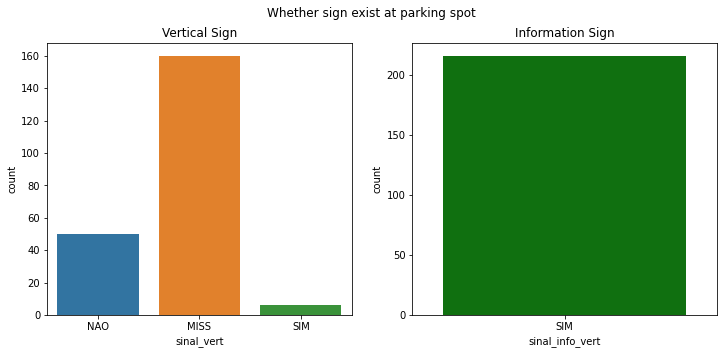

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
sns.countplot(x = scooter_park_features['sinal_vert'], ax = ax[0]);
sns.countplot(x = scooter_park_features['sinal_info_vert'], ax = ax[1], color='g');

plt.suptitle('Whether sign exist at parking spot');
ax[0].set_title('Vertical Sign');
ax[1].set_title('Information Sign');

### 2.1.4 Number of Parking units at each Spot

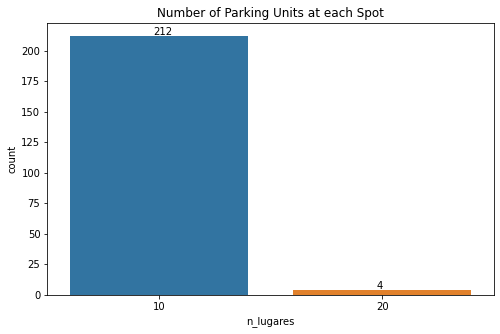

In [ ]:
fig, ax = plt.subplots(figsize = (8,5))
plt.title('Number of Parking Units at each Spot')
ax = sns.countplot(x = scooter_park_features['n_lugares']);

for p in ax.patches:
  ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + 0.375, p.get_height()+1))

In [ ]:
# Instantiate a feature group for the incidents in the dataframe
latitude = scooter_park_features['y'].mean()
longitude = scooter_park_features['x'].mean()
park = folium.Map(location=[latitude, longitude], zoom_start=13)

# create cluster
marker_cluster = MarkerCluster().add_to(park)

# create the dictionary to map n_lugares (parking unite) number with color
n_lugares = {10:'blue', 20:'orange'}

# Loop through the prediction and add each to the incidents feature group
for lat, long, n_spot, name in zip(scooter_park_features.y, scooter_park_features.x
                             , scooter_park_features.n_lugares
                             , scooter_park_features.toponimo):
    name = name + ' parking unit:' + str(n_spot)
    marker_cluster.add_child(
        folium.Marker(
            [lat, long],
            icon = Icon(color = n_lugares[n_spot]),
            popup = Popup(name, max_width = '100%')
        )
    )



park.add_child(marker_cluster)

Much higher number of parking slots per station is observed towards city center, and as we presumed since the demand for transportation in such area is significantly higher. 

### 2.1.5 Parking Spots in each neighbourhood

In [ ]:
# geojson of Porto neighbourhood
porto_neighborhood_url = 'https://gist.githubusercontent.com/stepps00/11ccb8af26dceb84b525c52ff62182df/raw/a028af44c9cdac4dbb2606b1cfd1f68595edb3e6/porto_neighbourhoods.geojson'
porto_neighborhood = requests.get(porto_neighborhood_url)
porto_neighborhood = gpd.GeoDataFrame().from_features(porto_neighborhood.json())

# add centroid to the dataset for further preparation
porto_neighborhood['center'] = porto_neighborhood['geometry'].centroid

In [ ]:
def in_which_neighbourhood(long, lat, df_neighbourhood = porto_neighborhood):
  '''
  check out the dot in which neighbour
  output - list of boolean 
  '''
  temp_point = Point(long, lat) # define the point
  result = [] # define the output list for boolean results

  for _, row in df_neighbourhood.iterrows(): # iter through all neighboorhood
    result.append(temp_point.within(shape(row['geometry'])))
  
  return result

In [ ]:
# check out each parking spot in which neighbourhood
park_neighboorhood = scooter_park_features.apply(
    lambda row: in_which_neighbourhood(row['x'], row['y']), axis=1)

porto_neighborhood_benchcount = porto_neighborhood.copy()
# reformat it into a dataframe
park_neighboorhood = pd.DataFrame.from_records(park_neighboorhood)
park_neighboorhood.columns = porto_neighborhood_benchcount['wof_name'].values

# check out if the point only belongs to one neighborhood
park_neighboorhood['count'] = park_neighboorhood.sum(axis = 1)
print('{} parking spot belongs to exactly one neighbour'\
      .format((park_neighboorhood['count'] == 1).sum()))

# remove the count columns
park_neighboorhood.drop(columns = ['count'], inplace = True)
# add the neighborbood information back to features
scooter_park_features['neighborhood']= park_neighboorhood.idxmax(1)

# add the count of parking spots back to neighborhood map
porto_neighborhood_benchcount['count'] = park_neighboorhood.sum(axis = 0).values

216 parking spot belongs to exactly one neighbour


In [ ]:
# save to reproduce
# need_col = ['geometry', 'wof_name', 'count']
# file_name = "porto_neighborhood_benchcount.geojson"
# porto_neighborhood_benchcount[need_col].to_file(file_name, driver="GeoJSON")

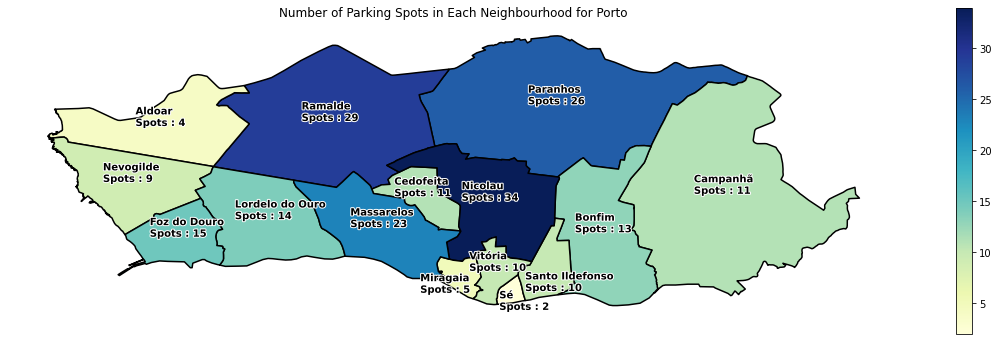

In [ ]:
# set the range for the choropleth
vmin = porto_neighborhood_benchcount["count"].min()
vmax = porto_neighborhood_benchcount["count"].max()

# create figure and axes for Matplotlib
fig, ax = plt.subplots(figsize=(20, 6))

#create map
porto_neighborhood_benchcount.plot(column="count", cmap="YlGnBu"
  , linewidth=1.5, ax=ax, edgecolor='black')
plt.title('Number of Parking Spots in Each Neighbourhood for Porto')

# remove the axis
ax.axis("off")

# Create colorbar legend
sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)

#add rank labels
texts = []

# add text to the graph
for idx, row in porto_neighborhood_benchcount.iterrows():
  point = row["center"]
  long, lat = point.x - 0.005, point.y
  label = '%s \nSpots : %s' % (row['wof_name'], row['count'])

  # adjust the label for some areas
  if row['wof_name'] == 'Sé':
    lat -= 0.003
    long += 0.003
  elif row['wof_name'] == 'Miragaia':
    lat -= 0.003
    long -= 0.002
  elif row['wof_name'] == 'Vitória':
    # lat -= 0.001
    long += 0.0005
  elif row['wof_name'] == 'Santo Ildefonso':
    lat -= 0.004
    long += 0.001
  texts.append(plt.text(long, lat, label, fontsize = 10, fontweight='bold' ). \
                set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]))

After determining the perimeter of each jurisdictional neighborhood in the City of Porto, we mapped the number of parking spots by neiborhood. A neighborhood with larger area doesn't necessarily have more parking spots since some peripheral neighborhoods have generally less population. 

### 2.1.6 Parking Spots and Bus/Metro Station

In this section, we use the bus and metro stop data provided by google. We will pick the stations that lies within the City of Porto boundary and apply those stops later in our case.

In [ ]:
# read the metro and bus stop information
metro_stop_url = '/content/metro/google_transit_dez2021/stops.txt'
metro_stop = pd.read_csv(metro_stop_url)
bus_stop_url = '/content/bus/stops.txt'
bus_stop = pd.read_csv(bus_stop_url)

# geojson of Porto neighbourhood
porto_border_url = 'http://polygons.openstreetmap.fr/get_geojson.py?id=3372453&params=0'
porto_border = gpd.read_file(porto_border_url)

In [ ]:
# check out bus/metro stop in porto
metro_stop['in'] = metro_stop.apply(
    lambda row: in_which_neighbourhood(row['stop_lon']
                                       , row['stop_lat']
                                       , porto_border), axis=1)
bus_stop['in'] = bus_stop.apply(
    lambda row: in_which_neighbourhood(row['stop_lon']
                                       , row['stop_lat']
                                       , porto_border), axis=1)

# add column to identify the metro and bus
metro_stop['type'] = 'metro'
bus_stop['type'] = 'bus'

# merge together
metro_bus_stops = pd.concat([metro_stop, bus_stop], ignore_index = True)
metro_bus_stops['in'] = metro_bus_stops['in'].str[0]
# pick only inside stops
metro_bus_stops = metro_bus_stops[(metro_bus_stops['in'] == True)]

# save as csv
metro_bus_stops.to_csv('metro_bus_stops.csv', index = False)

## 2.2 E-Scooter OD

### 2.2.1 General

This dataset contains all the e-scooter trips. Each row is recorded once the event of the e-scooter is changed.

It contains three different timestamps:
+  `record` - timestamp of record
+  `timestamp` - timestamp of recorded event change
+  `telemetry_timestamp` - timestamp of the measured telemetry

It also contains three different id:
+ `trip id` identify the uniqueness of each trip when customer is using.
+ `devide_id` is unique for each e-scooter
+ `id` is unique for each row 

`lat` and `long` provides the geo location of the e-scooter.

The e-scooter status is explained by `vehicle_status` at time of recorded event. It could be avaialble, removed, elsewhere, on_trip.

In [ ]:
od_url = '/content/Soft-Mobility/E-Scooter OD/wdl_od_view.csv'
od = pd.read_csv(od_url)

# change the time column into datetime
od['recorded'] = pd.to_datetime(od['recorded'], unit = 'ms')
od['timestamp'] = pd.to_datetime(od['timestamp'], unit = 'ms')
od['telemetry_timestamp'] = pd.to_datetime(od['telemetry_timestamp'], unit = 'ms')
od.head()

recorded    id                             device_id  \
0 2021-10-21 09:38:35.769     1  a7990baa-909e-42ed-8546-a2a9d2e42b3c   
1 2021-10-27 13:41:57.495  1223  abf136d8-a3d4-4d5f-92bf-70f5986fc5cb   
2 2021-10-26 21:13:10.287     3  a0623c68-106a-4275-a059-0f10645d7367   
3 2021-10-27 13:41:59.299  1224  035ba91e-6e01-475f-8ec7-ba0933feb6a1   
4 2021-10-26 21:13:12.989     5  438f37e9-53cd-450c-9110-5528b1ab0871   

            timestamp                event_types vehicle_state  trip_state  \
0 2021-10-20 12:48:03  {trip_leave_jurisdiction}     elsewhere         NaN   
1 2021-10-27 13:41:57      {maintenance_pick_up}       removed         NaN   
2 2021-10-26 21:13:10               {trip_start}       on_trip         NaN   
3 2021-10-27 13:41:59      {maintenance_pick_up}       removed         NaN   
4 2021-10-26 21:12:08               {trip_start}       on_trip         NaN   

  telemetry_timestamp                               trip_id        lat  \
0 2021-10-20 12:47:59  6e073f7f-b955-4033-b7bd-6237faa51507  41.147263   
1 2021-10-27 13:41:53                                   NaN  41.168862   
2 2021-10-26 21:09:15  cfc0bda1-067d-4470-881c-a6de48cd0d61  41.148018   
3 2021-10-27 13:41:55                                   NaN  41.168777   
4 2021-10-26 21:07:55  c62fe7e8-be9b-4380-8565-c1932bb3322a  41.145118   

        lng  
0 -8.674807  
1 -8.671213  
2 -8.665110  
3 -8.671162  
4 -8.612310

__According to the explaination in the Challenge Support, 'unspecified' tag is always ignored, because they ususally do not offer anything meaningful.__

Therefore here, we are going to follow the same step as the challenge explanation.

In [ ]:
# drop the unspecified
od_no_unspecified = od[~od['event_types'].str.contains('unspecified')]

In [ ]:
print('The records we have are from {} and {}'\
      .format(str(od['timestamp'].min()), str(od['timestamp'].max())))
print('There are {} records in this dataset.'.format(od.shape[0]))
print('There are in all {} e-scooter'.format(od['device_id'].nunique()))

print('\nAfter dropping the unspecified cases.')
print('The records we have are from {} and {}'\
      .format(str(od_no_unspecified['timestamp'].min()), 
              str(od_no_unspecified['timestamp'].max())))
print('There are {} records in this dataset ({:.2f}% of original).'\
      .format(od_no_unspecified.shape[0], od_no_unspecified.shape[0]/od.shape[0] * 100))
print('There are in all {} e-scooter'.\
      format(od_no_unspecified['device_id'].nunique()))

The records we have are from 2021-10-20 12:48:03 and 2022-03-09 12:04:46
There are 489279 records in this dataset.
There are in all 3720 e-scooter

After dropping the unspecified cases.
The records we have are from 2021-10-20 12:48:03 and 2022-03-09 12:04:46
There are 408360 records in this dataset (83.46% of original).
There are in all 3696 e-scooter


###  2.2.2 Vehicle State

While the majority of the scooter data has vehicle state marked as known, we do have 13.51% of unknown vehicle state. Possible reasons can be: vehicle out of range, out of battery, system failure, etc. 

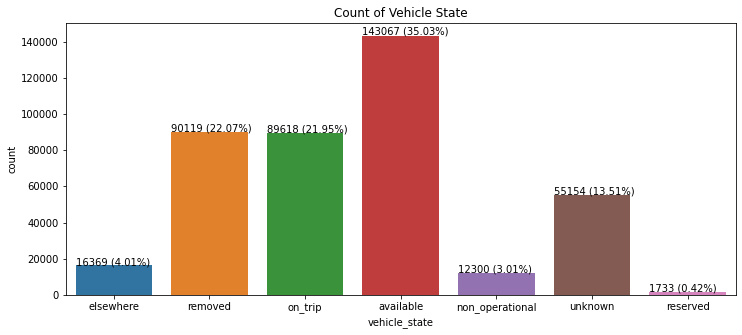

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
plt.title('Count of Vehicle State')
sns.countplot(x = 'vehicle_state', data = od_no_unspecified)

for p in ax.patches:
  h = p.get_height()
  ax.annotate('{:.0f} ({:.2f}%)'.format(h, h / od_no_unspecified.shape[0] * 100)
  , (p.get_x(), h * 1.005))

### 2.2.3 Event Types



As we have discovered in the last section, some record contain more than one event. Therefore, the first step of us is to create a new dataframe that map the record id with event type so that it will comply in the second normal form of Database Management Systems. 
+ each row only contains one event. 
+ If there exist more than one event for that record id, we will duplicate the record id and add another row

As we can see from the following result, that the new dataset `record_event_single` contains three columns:
+ `id`
+ `event_types`
+ `event_counts` - this an extra column we add to track how many event types happened for that record id

In [ ]:
# pull out the recorded id and eventes types
record_event = od_no_unspecified[['id', 'event_types']].copy()
# remove the dictionary bracket 
record_event['event_types'] = record_event['event_types'].str.replace('{', '')\
  .str.replace('}', '')

# since some rows has more than one events
# we flatten the dataframe so that each row contains only one events
record_event_single = []
for idx, row in record_event.iterrows():
  event_temp = row['event_types'].split(',')
  l = len(event_temp) # track how many event for that record
  for e in event_temp:
    record_event_single.append([row['id'], e, l])
# rename the columns
record_event_single = pd.DataFrame(record_event_single)
record_event_single.columns = ['id', 'event_types', 'event_counts']

record_event_single.head()

id              event_types  event_counts
0     1  trip_leave_jurisdiction             1
1  1223      maintenance_pick_up             1
2     3               trip_start             1
3  1224      maintenance_pick_up             1
4     5               trip_start             1

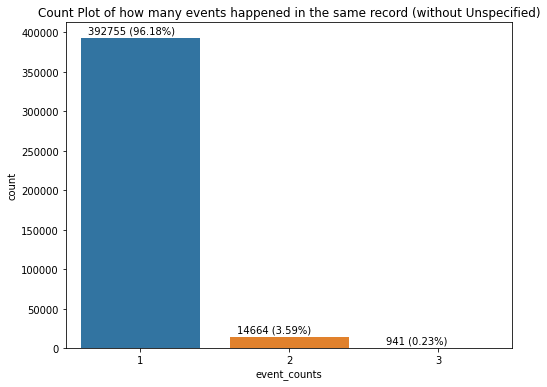

In [ ]:
# add the event count row back to the original dataset
record_event_count = record_event_single.copy()
record_event_count = record_event_count[['id', 'event_counts']].drop_duplicates()
od_no_unspecified.loc[:, 'event_counts'] = record_event_count.loc[:, 'event_counts'].values

# check out events types count distribution
fig, ax = plt.subplots(figsize = (8,6))
sns.countplot(x = od_no_unspecified['event_counts']);
plt.title('Count Plot of how many events happened in the same record (without Unspecified)')

# add annotation
for p in ax.patches:
  n = od_no_unspecified.shape[0]
  h = p.get_height()
  plt.annotate('{:.0f} ({:.2f}%)'.format(h, h * 100 /n), (p.get_x() + 0.05, h + 5000));

#### 2.2.3.1 Single Event Records

From the previous plot, we can see that most of the records only got one event. After seperating those single-event records and linking them with their vehicle types, we summarize the following relationship.
+ The blue bar at the top - `vehicle type`
+ The white box under - potential `event type` along with the `vehicle type` on the top

![](https://raw.githubusercontent.com/rainieluo2016/WDL_AKITA/main/Stage_02_2022/vehicle_event.PNG)

In [ ]:
# seperate single event records
condition = (record_event_single['event_counts'] == 1)
matched_record = record_event_single[condition][['id']].drop_duplicates()
matched_record = matched_record.merge(od_no_unspecified, how = 'left', on = ['id'])
single_event = matched_record.groupby(['event_types', 'vehicle_state']).size().reset_index(name = 'count')
single_event['event_types'] = single_event['event_types'].str.replace('{', '')\
  .str.replace('}', '')
single_event.sort_values(by=['vehicle_state', 'event_types'], inplace = True)

#### 2.2.3.2 Multiple Event Records

While checking out the dataset, we realise that when the same record has multiple events, __the last event__ listed in the `event_types` (seperated by comma) is the deterministic event that define the `vehicle_state`.

For example in the dataset, record that has 
+ id - 1226
+ event types - located, battery_low
+ vehicle_state - non_operational

According to we have concluded from the single event records, 
+ `located` has vehicle_state `available`  
+ `battery_low` has vehicle_state `non_operational`

This implies that the `vehicle_state` of record id 1226 is determined by the event listed at the last which is `battery low`

In order to verify this conclusion, what we did is to
+ extract the last listed event for those multi event cases
+ check the vehicle status that correlated to that last listed event
+ determine whether the recorded vehicle status is the same as the vehicle status that correspond to the last listed event 

From the following print out result, we can see all the multi-event cases got a match which prove our assumption.

In [ ]:
# seperate out multiple events
condition = (record_event_single['event_counts'] > 1)
matched_record = record_event_single[condition][['id']].drop_duplicates()
matched_record = matched_record.merge(od_no_unspecified, how = 'left', on = ['id'])
multi_event = matched_record.groupby(['event_types', 'vehicle_state']).size().reset_index(name = 'count')
multi_event['event_types'] = multi_event['event_types'].str.replace('{', '')\
  .str.replace('}', '')

# extract the last event which seperated by comma
last_event = []
for idx, row in multi_event.iterrows():
  last_event.append(row['event_types'].split(',')[-1])
multi_event['last_event'] = last_event

# rename the dataframe to avoid duplicate names
multi_event.columns = ['multi_events', 'multi_vehicle_state', 'multi_count', 'multi_last_event']

# merge the last event of multi with single event case to verify the vehicle state
multi_event_total = multi_event.merge(single_event, how = 'left'\
                                      , left_on = ['multi_last_event']\
                                      , right_on = ['event_types'])

print('Number multi-event records which the last listed event does not determine its vehicle status: ',
  (multi_event_total['multi_vehicle_state'] != multi_event_total['vehicle_state']).sum())

Number multi-event records which the last listed event does not determine its vehicle status:  0


### 2.2.4 Missing Values

We can see that there exist two columns contain missing value. 
+ `trip_state` is a column that all null according to the official dictionary
+ We would like to figure out the reason of missing value in `trip_id`

In [ ]:
od_no_unspecified.isna().sum()

recorded                    0
id                          0
device_id                   0
timestamp                   0
event_types                 0
vehicle_state               0
trip_state             408360
telemetry_timestamp         0
trip_id                228911
lat                         0
lng                         0
event_counts                0
dtype: int64

In [ ]:
# filter out the record that is related with trip
trip_contains = record_event.copy()
trip_contains['trip_related'] = record_event['event_types'].str.contains('trip')
trip_contains.drop(columns = ['event_types'], inplace = True)
trip_contains.drop_duplicates(inplace = True)

# merge back to the original dataset
od_no_unspecified = od_no_unspecified.merge(trip_contains, how = 'left', on = ['id'])

# create the dataframe for plot
trip_id_miss = od_no_unspecified[['trip_related', 'trip_id']].copy()
trip_id_miss['trip_id_miss'] = trip_id_miss['trip_id'].isna()

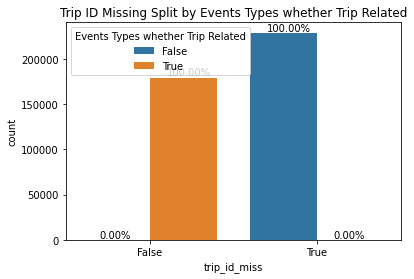

In [ ]:
fig, ax = plt.subplots()
plt.title('Trip ID Missing Split by Events Types whether Trip Related');
sns.countplot(x = 'trip_id_miss', hue = 'trip_related', data = trip_id_miss);
plt.legend(title = 'Events Types whether Trip Related', loc = 'uppper left');
total = trip_id_miss.groupby(['trip_id_miss']).size().values

idx = 0
for p in ax.patches:
  h = p.get_height()
  if h != h:
    h = 0
  x = p.get_x()
  total_idx = idx // 2 
  plt.annotate('{:.2f}%'.format(h * 100/ total[1-total_idx])
    , (x + 0.1, h + 2000))
  idx += 1

### 2.2.5 Seperate Time

+ recorded - timestamp of record
+ timestamp - timestamp of recorded event change
+ telemetry_timestamp - timestamp of the measured telemetry

In order to be consistent, we would like to choose `timestamp` column as the main time because we are more interested in when the trip status has been change. For example, trip start and trip end.

#### 2.2.5.1 Time Difference

Since we only refering `timestamp` column, but at the same time we still need trip location information. We would like to make sure these two time do not have large difference and will not affect our analysis on trip status.

In [ ]:
# compare the timestamp and the telemetry time
time = od_no_unspecified['timestamp'] - od_no_unspecified['telemetry_timestamp']
time = pd.DataFrame({'diff_loc_ahead': time})
time[['id', 'vehicle_state']] = od_no_unspecified[['id', 'vehicle_state']]
time['diff_loc_ahead_min'] = time['diff_loc_ahead'].dt.seconds // 60

# calculate the time difference
time['diff_range'] = np.where(time['diff_loc_ahead_min'] <=10 , '0-10',
                              np.where(time['diff_loc_ahead_min'] <=50 , '10-50', 
                                       np.where(time['diff_loc_ahead_min'] <=200 , '50-200', 
                                                np.where(time['diff_loc_ahead_min'] <=1000 , '200-1000', '> 1000'))))

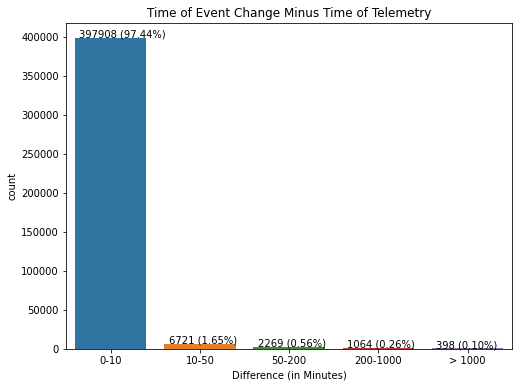

In [ ]:
# plot
fig, ax = plt.subplots(figsize = (8, 6))
sns.countplot(x = time['diff_range'], order=['0-10', '10-50', '50-200', '200-1000', '> 1000']);
for p in ax.patches:
  ax.annotate('{:.0f} ({:.2f}%)'.format(p.get_height(), p.get_height() / time.shape[0] * 100), 
              (p.get_x() + 0.05, p.get_height() + 1000))

plt.title('Time of Event Change Minus Time of Telemetry');
plt.xlabel('Difference (in Minutes)');

We can see that most of the time diffence between trip status and location information received is lower than 10 minutes. About __97.44%__ of the cases fall in the section. 

#### 2.2.5.2 Time Demolition - Only Trip Related

In [ ]:
od_no_unspecified['timestamp'].min(), od_no_unspecified['timestamp'].max()

(Timestamp('2021-10-20 12:48:03'), Timestamp('2022-03-09 12:04:46'))

As we can see that the min time for the whole records is October 2021 and max time is March 2022. Therefore, this is meaningless to visualize on year and month. We would then:
+ Filter only trip related cases (events like maintenance will also included but they are not related to customer pattern of using the e-scooters)
+ Visualize the trip through by hour and weekdays. 

In [ ]:
od_no_unspecified['timestamp_month'] = od_no_unspecified['timestamp'].dt.month
od_no_unspecified['timestamp_year'] = od_no_unspecified['timestamp'].dt.year
od_no_unspecified['timestamp_hour'] = od_no_unspecified['timestamp'].dt.hour
od_no_unspecified['timestamp_day'] = od_no_unspecified['timestamp'].dt.strftime('%A')

# trip related
trip_only = od_no_unspecified[od_no_unspecified['trip_id'].notna()]

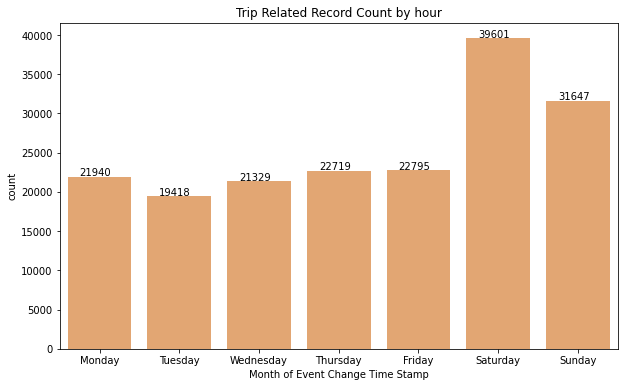

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
# sns.set_theme(style="")
week_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.countplot(x = 'timestamp_day', data = trip_only
                   , color = 'sandybrown'
                   , order = week_order)
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
              (p.get_x() + 0.15, p.get_height() + 100), fontsize = 10)
ax.set(title = 'Trip Related Record Count by hour');
plt.xlabel('Month of Event Change Time Stamp');

The total number of hours recorded is the highest during weekends, especially on Saturday, and mostly even from Monday to Friday. 

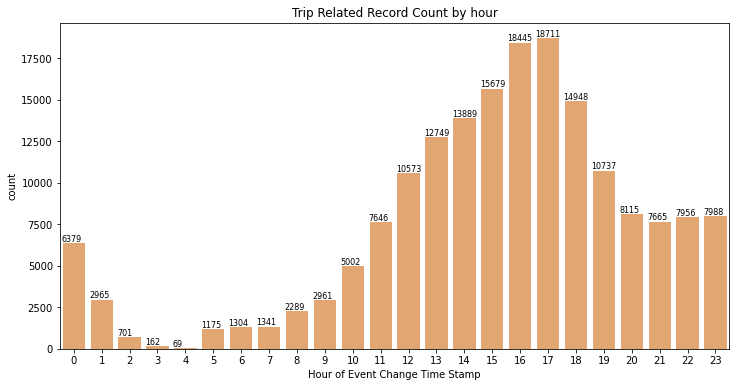

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# sns.set_theme(style="")
ax = sns.countplot(x = 'timestamp_hour', data = trip_only, color = 'sandybrown')
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), 
              (p.get_x() - .05, p.get_height() + 100), fontsize = 8)
ax.set(title = 'Trip Related Record Count by hour');
plt.xlabel('Hour of Event Change Time Stamp');

In a given day, the highest demand for escooters occurs during afternoon hours, approximately from 12pm to 17pm. Althogh trip records occur at every hour, our research suggests that the City of Porto does not allow the operation of escooters after 10pm. 

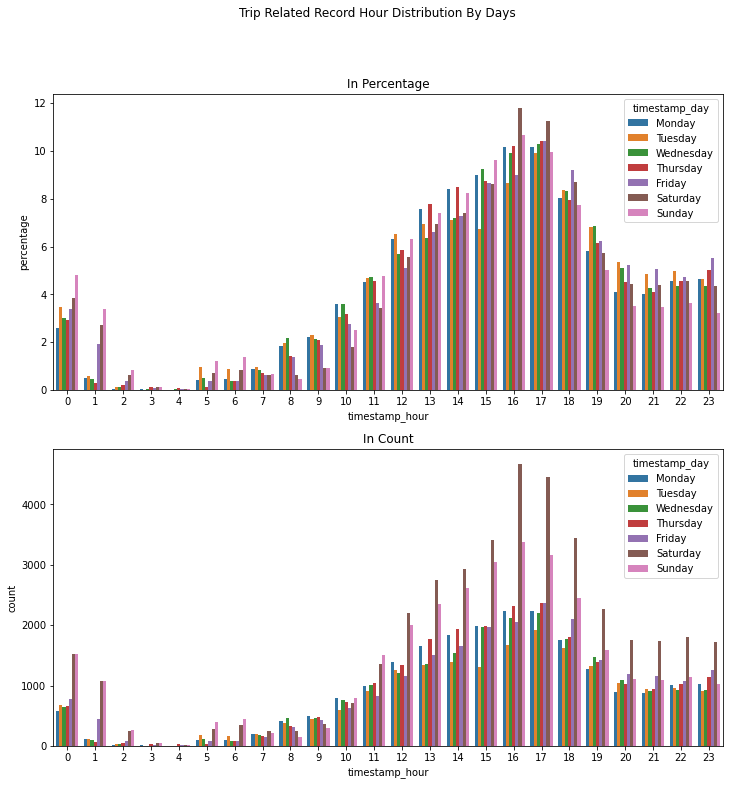

In [ ]:
# prepare percentage plot
time_pct = (trip_only.groupby(['timestamp_day'])['timestamp_hour']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('timestamp_hour'))


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (12, 12))
plt.suptitle('Trip Related Record Hour Distribution By Days')
sns.barplot(x="timestamp_hour", y="percentage"
            , hue="timestamp_day", data=time_pct, ax = ax1, hue_order = week_order);
ax1.set_title('In Percentage');

sns.countplot(x="timestamp_hour", hue="timestamp_day", data=trip_only
              , hue_order = week_order, ax = ax2);
ax2.set_title('In Count');

We'd like to investigate whether the higher demand in afternoon hours trend is persistent in terms of days in a week. And as the barplot shows, the distribution of each day of week is almost identical, meaning for each day of a week, the highest demand for escooters occur during early-mid afternoon hours. However, one finding is that although according to our research, the city has regulations against the operation of escooters after 10pm, the data suggests otherwise. 

### 2.2.6 Transform the OD Dataset

Here we will change the dataset so that each __complete and valid trip__ will be one row contains information about the start and end. 
+ There exists 79873 unique `trip_id` in this data 
+ Idealy, we thought for each trip_id, there should contain two record, one for `trip_start`, one for `trip_end`. But the data show something else from the following plot:
  + we can see that about __0.22%__ trip id contains one record
    + this means that the trip is not fully documented and is not valid for analyzing
    + therefore we would remove those records.
  + Most of the `trip_id` (__93%__) contains two record
  + The rest __6.75%__ records contains more than two records
    + This could happens if the e-scooter leave the jurisdiction and then re-enter. Leave and enter jurisdiction are also considered as event and will be documented
    + therefore we will consider the earliest as the start record and the latest as the end record.

#### 2.2.6.1 Filter Trip-Related

In [ ]:
# count number of record under the same trip id
trip_id_count = trip_only.groupby(['trip_id']).size().reset_index(name = 'same_trip_id')
trip_id_count.sort_values(by = ['same_trip_id'], inplace = True)
trip_id_count['same_trip_id_count'] = np.where(trip_id_count['same_trip_id'] == 1, '1', 
                                               np.where(trip_id_count['same_trip_id'] == 2, '2', 'more than 2'))

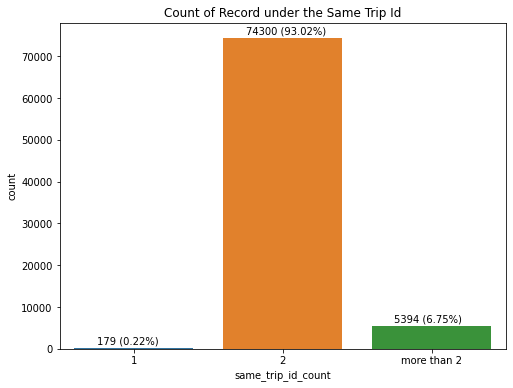

In [ ]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.countplot(trip_id_count['same_trip_id_count'], order = ['1', '2', 'more than 2']);
plt.title('Count of Record under the Same Trip Id');

for p in ax.patches:
  h = p.get_height()
  plt.annotate('{:.0f} ({:.2f}%)'.format(h, h/trip_id_count.shape[0] * 100), (p.get_x() + .15, h + 1000))

Transform the dataset according to we have listed above each row is full trip with start record info (id, timestamp, location, etc) and end record info.

In [ ]:
# earlist record of the same trip id
trip_start = trip_only.groupby(['trip_id'])['timestamp'].min().reset_index(name = 'start_timestamp')
trip_end = trip_only.groupby(['trip_id'])['timestamp'].max().reset_index(name = 'end_timestamp')

# merge together so that to get the earliest and latest time for same trip
full_trip = trip_start.merge(trip_end, on = ['trip_id'], how = 'left')

# merge for the start and the end
full_trip = full_trip.merge(trip_only, left_on = ['trip_id', 'start_timestamp']
                            , right_on = ['trip_id', 'timestamp']
                            , how = 'left')
full_trip = full_trip.merge(trip_only, left_on = ['trip_id', 'end_timestamp']
                            , right_on = ['trip_id', 'timestamp']
                            , how = 'left')

# rename the columns
keep = ['trip_id', 'device_id_x', 
        'id_x', 'start_timestamp', 'event_types_x', 'vehicle_state_x', 
        'telemetry_timestamp_x', 'lat_x', 'lng_x',
        'id_y', 'end_timestamp', 'event_types_y', 'vehicle_state_y',
        'telemetry_timestamp_y', 'lat_y', 'lng_y']
rename = ['trip_id', 'device_id', 
          'start_id', 'start_timestamp', 'start_event_types', 'start_vehicle_state',
          'start_telemetry_timestamp', 'start_lat', 'start_lng',
          'end_id', 'end_timestamp', 'end_event_types', 'end_vehicle_state',
          'end_telemetry_timestamp', 'end_lat', 'end_lng']
full_trip = full_trip[keep].copy()
full_trip.columns = rename

# keep rows that start record id is different from end record id
full_trip_both = full_trip[full_trip['start_id'] != full_trip['end_id']].copy()
full_trip_both.to_csv('full_trip_both.csv', index = False)

#### 2.2.6.2 Visualize Trip Duration

Once get truely escooter trip records, we would like to how long most of the customers use e-scooters. That's why we would like to plot the boxplot to see.

In [ ]:
# get geometry point for each trip
trip_start_geometry = [Point(a, b) for a, b in \
            zip(full_trip_both.start_lng, full_trip_both.start_lat)]
# calculate the trip duration time in minutes
trip_demand = pd.DataFrame({'trip_duaration_minutes':full_trip_both['end_timestamp'] - full_trip_both['start_timestamp']})
trip_demand['trip_duaration_minutes'] = round(trip_demand['trip_duaration_minutes'].dt.seconds / 60, 4)
# merge them into a geopandas dataframe
trip_demand = gpd.GeoDataFrame(trip_demand
    , geometry=trip_start_geometry
    , crs={'init':'epsg:4326'})

# add in unique key - trip id
trip_demand['trip_id'] = full_trip_both['trip_id']

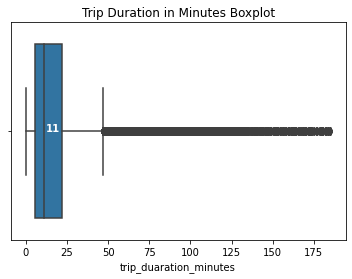

In [ ]:
plt.title('Trip Duration in Minutes Boxplot')
sns.boxplot(trip_demand['trip_duaration_minutes']);

medians = trip_demand['trip_duaration_minutes'].median()
plt.annotate('{:.0f}'.format(medians), (medians + 1 , 0),color='w',weight='semibold');

We can see that the duration is also very skewed to the right. The median of the trip duration is about 11 minutes. Most of the trips take around 10 -20  minutes. But on the right tail, there are quite a few extreme long trip. So we would like to use the percentile to represent the duration in minutes because 

+ it considers the trip duration pattern and time length at the same time without adding to much value to the extreme duration time.
+ Other way of standardization such as max-min and mean-standard deviation will result with negative or zero which we do not want. 



In [ ]:
trip_demand.loc[:, 'trip_duaration_pct'] = trip_demand['trip_duaration_minutes'].rank(pct=True)

In [ ]:
# save to reproduce
trip_demand.to_file("trip_demand.geojson", driver="GeoJSON")

# 3. Model

## 3.1 Preparation

In this section we prepare the necessary components for optimization, including
+ Demand Point $j$ and its demand quantity $W_j$ 
+ Potential Candidate Point $i$ and its market share or population attracted to the e-scooter drop-off station $M_i$

### 3.1.1 Demand Point

According to the [News Porto](https://www.porto.pt/en/news/electric-scooters-are-set-to-go-and-ride-through-porto-starting-1st-june), 

> *e-scooters should provide an excellent alternative to the automobile when it comes to short distance travels, and an optimal complement to public transportation.*

Therefore, a great share of the e-scooter demand should come from the bus and metro passengers so that they can arrive at their destinantions faster and easier with scooter.

_We also think that the combination of scooter station and bus/metro station is more convenient for user to find and drop-off.


So we decide to consider the **demand point $J$ as the bus and metro stops**. 


We use the following notation to indicate:
+ $j$ - for each demand point (bus/metro station)
+ $k$ - for each trip record


As for the demand quantity ($W_j$) for each stop, it comes up with three components (severely skewed components should be rescaled or standardized):


+ $F_{j}$ - the hourly average passenger flow at each demand point $j$
+ $I_{j, {trip}_k}$ - whether ${trip}_n$ is closest to demand point (metro/bus station) $j$. If so, $I$ will have value 1 if not 0.
+ $T_{{trip}_k}$ - the duration time for e-scooter trips ${trip}_k$ 
+ $\sum_{{trip}_n} I_{j, {trip}_n} * T_{{trip}_n}$ is just the total duration time for trips classified to each demand point $j$

Finally, those three components will be combined together to get the total demand for each demand point which is

$$
W_j = F_{j} * \sum_{{trip}_n} I_{j, {trip}_n} * T_{{trip}_n}
$$

#### 3.1.1.1 Hourly average passenger flow 

From the official dataset, we are given 
+ the bus/metro stop locations as we have presented in the previous section
+ another two datasets are also provided by the officials which is the hourly passager flow at each bus/metro station during one year period
  + One extra step for Bus Station
    + Bus stations on the same street for both way might have the same name. 
    + Due to the difference of data imputing for bus direction (bus station passengner hourly flow and bus station location), we could only link those two dataset with the station name, but unable to even accurate to which direction the station is.
  + Therefore, we decide to assume the stations with the same name (on the same street) for both direction to have the same passanger flow.

Therefore, we decide to pick those bus/metro stations inside the city of Porto and calculate the hourly average passes.

In [ ]:
# load all folder names
summary_folder = '/content/InterMunicipality/InterMunicipality/TIP'

# load file names for hourly train and bus passengar flow
train_file = []
for i in os.listdir(summary_folder):
  train_file.extend(glob.glob(os.path.join(summary_folder, i, '*_Validações Ferrov.xlsx')))

bus_file = []
for i in os.listdir(summary_folder):
  bus_file.extend(glob.glob(os.path.join(summary_folder, i, '*_Validações Rodov.xlsx')))

calculate the $F_{t}$ - hourly average passenger flow for each station

In [ ]:
# create dictionary so that names for stations expressed diffferently 
# beween files could be mapped with each other
metro_name = {'Estádio do Dragão': 'Estadio do Dragao'
  , 'CP-Porto / Campanhã': 'Campanha', 'Campanhã': 'Campanha'
  , 'Heroísmo': 'Heroismo'
  , '24 de Agosto': '24 de Agosto'
  , 'Bolhão': 'Bolhao'
  , 'Trindade': 'Trindade'
  , 'Lapa': 'Lapa'
  , 'Carolina de Michaelis': 'Carolina Michaelis'
  , 'Casa da Música': 'Casa da Musica'
  , 'Francos': 'Francos'
  , 'Ramalde': 'Ramalde'
  , 'Viso': 'Via Rapida Viso'
  , 'CP-Porto / S. Bento': 'Sao Bento', 'São Bento': 'Sao Bento'
  , 'Aliados': 'Aliados'
  , 'Faria Guimarães': 'Faria Guimaraes'
  , 'Marquês': 'Marques'
  , 'Combatentes/Lima': 'Combatentes'
  , 'Salgueiros': 'Salgueiros'
  , 'Polo Universitário': 'Polo Universitario'
  , 'IPO': 'I.P.O.'
  , 'H. São João': 'Hospital de Sao Joao'
  , 'Contumil': 'Contumil'
  , 'Nasoni': 'Nasoni'
  , 'Nau Vitória': 'Nau Vitoria'
  }

# read through all the files and 
# calculate the hourly average for each metro during one year period
metro_total = []
for f in train_file:
  test = pd.read_excel(f)

  # replace the metro name as the same
  test_replace = test.replace({'Est/Op': metro_name})
  # filter the stops that is in Porto
  metro_stop_test = metro_stop.merge(test_replace
                                     , how = 'left'
                                     , left_on = ['stop_name']
                                     , right_on = ['Est/Op'])
  
  metro_stop_test = metro_stop_test[['stop_name', 'Validações']]
  metro_total.append(metro_stop_test)

metro_total = pd.concat(metro_total, ignore_index= True)
metro_total = metro_total.groupby(['stop_name'])['Validações']\
  .mean().reset_index(name = 'hour_mean')

# repeat the same step for bus stop too
bus_total = []
for i in bus_file:
  test = pd.read_excel(i)
  bus_stop_test = bus_stop.merge(test
                              , how = 'left'
                              , left_on = ['stop_name']
                              , right_on = ['Paragem'])
  bus_total.append(bus_stop_test)
bus_total = pd.concat(bus_total, ignore_index = True)

# calculate the hourly average
bus_stop_annual_mean_with_Sentido = bus_total\
  .groupby(['Sentido', 'Paragem'])['Validações']\
  .mean()\
  .reset_index(name = 'mean_Validações')

# considering the direction
bus_stop_annual_mean_with_Sentido.columns = ['Sentido', 'stop_name', 'hour_mean']
# do not consider direction
bus_stop_annual_mean = bus_total.groupby(['stop_name'])['Validações']\
  .mean()\
  .reset_index(name = 'hour_mean')

# group bus and the metro demand together
demand = pd.concat([metro_total, bus_stop_annual_mean], ignore_index = True)

combine the geometry info of each location with hourly average passenger flow

In [ ]:
# merge the point geo info 
demand_stops = metro_bus_stops.copy()
demand_stops = demand_stops.merge(demand, how = 'left', on = ['stop_name'])
demand_stops.dropna(inplace = True)

geometry = [Point(a, b) for a, b in \
            zip(demand_stops.stop_lon, demand_stops.stop_lat)]
demand_stops = gpd.GeoDataFrame(
    demand_stops[['stop_id', 'stop_name']]
    , geometry=geometry
    , crs={'init':'epsg:4326'})

# add the hourly mean to geo info for demand point
bus_demand_single = bus_stop_annual_mean_with_Sentido\
  .groupby(['stop_name'])['hour_mean']\
  .mean().reset_index(name = 'hour_mean')

demand = pd.concat([metro_total, bus_demand_single], ignore_index = True)
demand.dropna(inplace = True)
demand_stops = demand_stops.merge(demand, how = 'left', on = ['stop_name'])
demand_stops.dropna(inplace = True)

demand_stops.columns = ['stop_id', 'stop_name', 'geometry', 'hour_mean_F']
demand_stops.reset_index(drop=True, inplace=True)

Finally, the passanger flow capacity of metro and bus is not at the same level. 

Even the bus stop and metro station are at the same region, they will not have the similar amount of passenger. As we can see from the following example. 

Therefore, we would like to rescale the metro passanger and bus passanger seperately by dividing their own median. So that they will at the same scale.

In [ ]:
demand_stops[(demand_stops['stop_name'] == 'Lapa')|(demand_stops['stop_name'] == 'LAPA' )]

In [ ]:
# seperate metro and bus
metro_F = np.array(demand_stops['hour_mean_F'][:24])
bus_F = np.array(demand_stops['hour_mean_F'][24:])

# rescale - divide by median
metro_F_std = metro_F / np.median(metro_F)
bus_F_std =  bus_F / np.median(bus_F)

station_type = ['metro'] * 24 + ['bus'] * 882
F_std = np.concatenate([metro_F_std,bus_F_std], axis = 0)
demand_stops['hour_mean_F_std'] = F_std
demand_stops['station_type'] = station_type

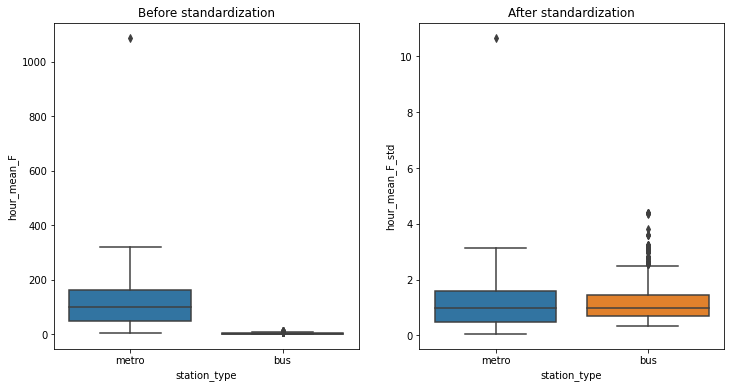

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
plt.title('Boxplot of Passenger flow at Each Station')

ax[0].set_title('Before standardization')
ax[1].set_title('After standardization')

sns.boxplot(y = 'hour_mean_F', x = 'station_type', data = demand_stops, ax = ax[0]);
sns.boxplot(y = 'hour_mean_F_std', x = 'station_type', data = demand_stops, ax= ax[1]);

#### 3.1.1.2 Classify Trip Origin Point to its closest Demand Point

Here we would like to classify the e-scooter trips to the demand points and add weight to the demand point capacity. Therefore,
+ find out e-scooter trip related records
  + as we have explained before, e-scooter OD dataset records different types of the e-scooter events and __only trip related records will have trip-id__. We will keep only those records __(what we did in 2.2.6)__
+ calculate the distance between the trip origin the demand points (metro/bus stops)
+ classify the trip to the closest demand point
  + we would also like to add a cap to limit classification using the distance between trip origin and its closest demand point to avoid extreme values

In [ ]:
# transform the geometry from degree to meters
trip_demand_meters = trip_demand.geometry.to_crs(epsg=3310)
demand_stops_meters = demand_stops.geometry.to_crs(epsg=3310)
# calculate the distance between points
dist_trip_demand = trip_demand_meters\
  .apply(lambda g: demand_stops_meters.distance(g))
# change to numpy array
dist_trip_demand_np = dist_trip_demand.to_numpy()

In [ ]:
# reset the np array, the min distance still hold its value, 0 for rest
trip_to_demand_point_dist = (dist_trip_demand_np == 
                             np.min(dist_trip_demand_np, axis = 1, keepdims = True))\
                             .view('i1')
trip_to_demand_point_dist = trip_to_demand_point_dist * dist_trip_demand_np

In [ ]:
# document the closest demand point idx and distance to trip dataset 
trip_demand['closest_demand_point_idx'] = dist_trip_demand_np.argmin(axis = 1)
trip_demand['closest_demand_point_dist'] = trip_to_demand_point_dist.max(1)

Once finish calculating the distance between the trip origin point and its closet demand point, we did a cumulative plot as below:
+ the cumulative plot is growing quickly to somewhere around 97% quantile (which is the red vertical line in the plot)
+ after that value, the distribution become way flattern.
+ Therefore, we determine the cutoff cap for distance to be 97% quantile (round to integer as 180 meters)

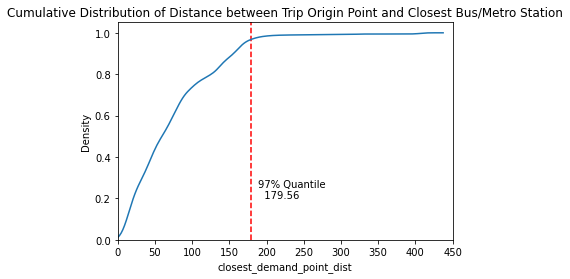

In [ ]:
fig, ax = plt.subplots()
plt.title('Cumulative Distribution of Distance between Trip Origin Point and Closest Bus/Metro Station')

pct_97 = trip_demand['closest_demand_point_dist'].quantile(0.97)
ax.axvline(pct_97, ls='--', color = 'red')
ax.text(pct_97 * 1.05, 0.2, "97% Quantile \n  {:.2f}".format(pct_97))

sns.kdeplot(trip_demand['closest_demand_point_dist'], cumulative = True, ax = ax);
ax.set(xlim=(0, 450));

In [ ]:
# apply the cap to distance
trip_to_demand_point_dist_cap = np.where(trip_to_demand_point_dist < 180, trip_to_demand_point_dist, 0)

In [ ]:
# change to dataframe for ease of saving
# trip_to_demand_point_dist_cap_df = pd.DataFrame(trip_to_demand_point_dist_cap)
# trip_to_demand_point_dist_cap_df.to_csv('trip_to_demand_point_dist_cap_df.csv', index = False)
# trip_to_demand_point_dist_cap_df.to_pickle('trip_to_demand_point_dist_cap_df.pkl')

#### 3.1.1.3 Number of Trips classfied to each Demand Points

From the boxplot in the left, we are still facing the highly skewed to the right issue and the range is extremely large.

Therefore, in order to pretain the distribution, we choose to represent it with its percentile.


In [ ]:
demand_stops['n_trip'] = trip_to_demand_point_dist_cap.sum(0)
demand_stops['n_trip_std'] = demand_stops['n_trip'].rank(pct=True)

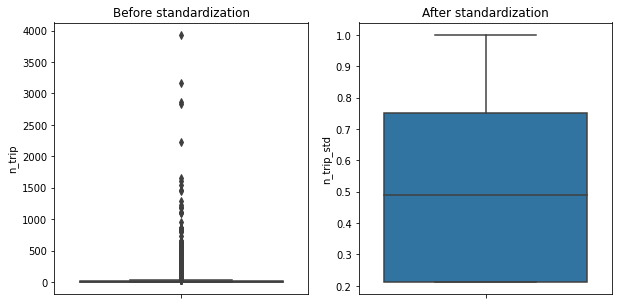

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.title('Boxplot of Number of Trip Classified to Each Station')

ax[0].set_title('Before standardization')
ax[1].set_title('After standardization')

sns.boxplot(y = 'n_trip', data = demand_stops, ax = ax[0]);
sns.boxplot(y = 'n_trip_std', data = demand_stops, ax= ax[1]);

#### 3.1.1.4 Combine everything for values of Demand Point

$$
W_j = F_{j} * \sum_{{trip}_n} I_{j, {trip}_n} * T_{{trip}_n}
$$

In [ ]:
# add duration time to the boolean classification matrix
trip_to_demand_point_dist_cap_bool = (trip_to_demand_point_dist_cap > 0).astype(int)
trip_duration = np.array(trip_demand['trip_duaration_minutes'])

demand_stops['I_T'] = np.dot(trip_duration.reshape(1, -1), trip_to_demand_point_dist_cap_bool).T
demand_stops['I_T_std'] = demand_stops['I_T'].rank(pct=True)

# time the result as we formulate 
demand_stops['W_Demand'] = demand_stops['hour_mean_F_std'] * demand_stops['I_T_std']

# save a copy
demand_stops.to_file("demand_stops.geojson", driver="GeoJSON")
trip_demand.to_file("trip_demand.geojson", driver="GeoJSON")

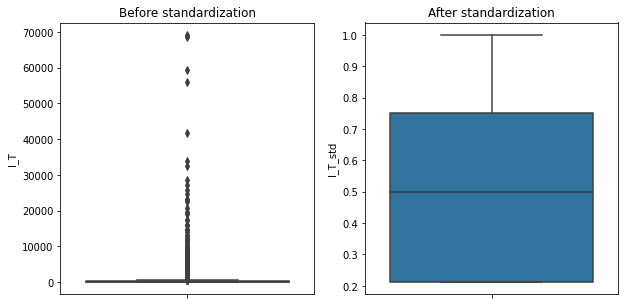

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
plt.title('Boxplot of Total Trip Duration Time for Trips to Each Station')

ax[0].set_title('Before standardization')
ax[1].set_title('After standardization')

sns.boxplot(y = 'I_T', data = demand_stops, ax = ax[0]);
sns.boxplot(y = 'I_T_std', data = demand_stops, ax= ax[1]);

__Right Side Summuration__

From the boxplot in the left, we are still facing the highly skewed to the right issue and the range is extremely large.

Therefore, in order to pretain the distribution, we choose to represent it with its percentile.

__Let's also see have many demand points in each district along with its weight__

In [ ]:
porto_neighborhood_demand = porto_neighborhood.copy()
# check out each parking spot in which neighbourhood
park_neighboorhood_demand = demand_stops.apply(
    lambda row: in_which_neighbourhood(row.geometry.x, row.geometry.y), axis=1)

# reformat it into a dataframe
park_neighboorhood_demand = pd.DataFrame.from_records(park_neighboorhood_demand)
park_neighboorhood_demand.columns = porto_neighborhood_demand['wof_name'].values

# get the which neighborhood each demand belongs to
park_neighboorhood_demand_name = park_neighboorhood_demand\
  .apply(lambda x: ','.join(x.index[x == 1]), axis=1)
demand_stops['wof_name'] = park_neighboorhood_demand_name

# for reproduce
# demand_stops.to_file('demand_stops_with_neighborhood.geojson', drive = 'GEOJSON')

# summarize for plot
demand_neighborhood_stat = demand_stops.groupby(['wof_name'])\
  ['W_Demand'].sum()\
  .reset_index(name = 'weighed_demand_count')

demand_neighborhood_stat_cnt = demand_stops.groupby(['wof_name'])\
  .size()\
  .reset_index(name = 'demand_count')

demand_neighborhood_stat = demand_neighborhood_stat.merge(
    demand_neighborhood_stat_cnt
    , how = 'left'
    , on = ['wof_name'])

# reproduce
demand_neighborhood_stat.to_csv('demand_neighborhood_stat.csv', index = False)

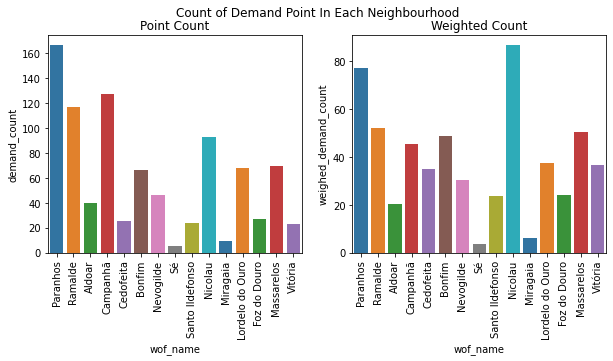

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10, 4))

plt.suptitle('Count of Demand Point In Each Neighbourhood');
neighhood_order = list(porto_neighborhood_demand['wof_name'].values)
sns.barplot(y = 'demand_count', x = 'wof_name'
            , data = demand_neighborhood_stat
            , palette = "tab10"
            , order = neighhood_order, ax = ax[0]);

sns.barplot(y = 'weighed_demand_count', x = 'wof_name'
            , data = demand_neighborhood_stat
            , palette = "tab10"
            , order = neighhood_order, ax = ax[1]);
ax[0].set_title('Point Count');
ax[1].set_title('Weighted Count');
ax[0].set_xticklabels(neighhood_order, rotation=90);
ax[1].set_xticklabels(neighhood_order, rotation=90);

From the previous plot, we can see that most of the neighbourhoods are relatively at the same ranks in both graphs except Nicolau. This is because Nicolau although Nicolau does not have that large of the area, it is the very center of City of Porto and also the most touristy area. That's why although it does not have the most demand points (metro/bus stations), those demand points add up the largest weight considering passenger flows and e-scooter trips duration. The current e-scooter parking stations design also have the most stations is Nicolau (in section 2.1.5). This further on prove our idea of considering passenger flows and e-scooter trips duration as weight for demand point is reasonable.

In [ ]:
# create the heatmap to visualize weight on map
geometry = [g for g in demand_stops['geometry']]
demand = [d for d in demand_stops['W_Demand']]
lat = []
lng = []

for loc in geometry:
    lat.append(loc.x)
    lng.append(loc.y)

demand_table = pd.DataFrame({'Lat':lat, 'Lng':lng, 'Demand': demand})


def generateBaseMap(loc, zoom=13.5, tiles='OpenStreetMap', crs='ESPG2263'):
    return folium.Map(location=loc,
                   control_scale=True, 
                   zoom_start=zoom,
                   tiles=tiles)

MAP = [latitude, longitude] 
  
base_map = generateBaseMap(MAP)

map_values1 = demand_table[['Lng','Lat','Demand']]

data = map_values1.values.tolist()

colormap = branca.colormap.linear.YlOrRd_09.scale(0, 8.131988)
gradient_map = defaultdict(dict)
           
hm = HeatMap(data, gradient_map)

# #base_map
base_map.add_child(hm)

Zooming in the heatmap, we observe that largers concentrated areas appear in the center of Porto, while the relatively minor neighborhoods in terms of demand show less concentrated patterns. 

### 3.1.2 Potential Candidate Point for Scooter Drop Off

In this section, we want discuss the candidate points and their coverage area/capacity :

+ The potential candidate points are
  + All the bus/metro station - considering if the scooter park station could be built together along with the bus and metro station, we could attract more commuters to use scooter to get to their destination
  + Current scooter parking station

+ Find out the demand points that could be covered by each candidate dropoff point
  + We conducted research on shared mobility in general, and bike-share is the most similar to escooters and has abundant studies performed. According to [Optimal locations for bikeshare stations: A new GIS based spatial approach](https://www.sciencedirect.com/science/article/pii/S2590198220300129) and [Bike-sharing: history, impacts, models of provision, and future](https://scholar.google.com/scholar_lookup?title=Bike-sharing%3A%20history%2C%20impacts%2C%20models%20of%20provision%2C%20and%20future&publication_year=2009&author=P.%20DeMaio), 

    > A distance of 300 m (0.19 miles) was considered to be an appropriate distance, one with which bikers would be comfortable walking from the bike station to reach their destination

    > Bike stations in Paris are located at a distance of every four blocks which amounts to 300 m, allowing easy access
    
    > However, we ought to keep in mind that escooters are more phisically accessible than bikes

  + Therefore, we could like to choose the range for coverage __300 meters__ as reference
    + The potential coverage of that candidate points will be the weight of all demand points within 300 meters.

+ Create avalibility matrix for co-occurance of candidate points to find out which pairs or groups of candidate point can not exist at the same time.

#### 3.1.2.1 Coverage for Each Candidate Point

In [ ]:
# get bus and metro stop info
candidate_1 = demand_stops[['stop_name', 'geometry']].copy()
candidate_1['id'] = str('metro/bus_') + demand_stops['stop_id']
candidate_1.columns = ['name', 'geometry', 'id']

#create geo dataframe for existing scooter-dropoff
geometry = [Point(a, b) for a, b in zip(scooter_park_features.x, scooter_park_features.y)]
candidate_2 = gpd.GeoDataFrame(
    scooter_park_features[['toponimo']]
    , geometry=geometry
    , crs={'init':'epsg:4326'})

# create id and rename to have the same column
candidate_2['id'] = str('scooter_') + scooter_park_features['objectid_1'].astype(str)
candidate_2.columns = ['name', 'geometry', 'id']

# merge together
candidate = gpd.GeoDataFrame(pd.concat([candidate_1, candidate_2], ignore_index=True))

In [ ]:
# change the point unit from degree to meters
candidate_meters = candidate.geometry.to_crs(epsg=3310)
demand_stops_meters = demand_stops.geometry.to_crs(epsg=3310)

# calculate the distance between candidate and demand
candidate_demand_dist = candidate_meters\
  .apply(lambda g: demand_stops_meters.distance(g))
candidate_demand_dist = candidate_demand_dist.to_numpy()

# select demand within 300 meter radius
candidate_demand_dist_bool = (candidate_demand_dist <= 300).astype(int)
candidate_coverage = candidate_demand_dist_bool * np.array(demand_stops['W_Demand']).reshape(1, -1)

W_candidate = candidate_coverage.sum(axis = 1)

# add back to candidate point dataset
candidate['W_candidate'] = W_candidate

In [ ]:
# save for reproduce
# candidate.to_file("candidate.geojson", driver="GeoJSON")

#### 3.1.2.2 Availibility Matrix for Co-ocurrance of Candidate Points

One of the constaints for our optimization is to limit the min distance between parking stations. Therefore, we would like to find which pairs of the candidate points could not be selected as the parking stations together since their distance is below the limitation.

We here choose the limitations as 40 meters, 300 meters and 200 meters. The detail reason for those choices will be explained during the optimzation.

In [ ]:
# calculate the distance between points
candidate_meters = candidate.geometry.to_crs(epsg=3310)
candidate_co_occur = candidate_meters\
  .apply(lambda g: candidate_meters.distance(g))

candidate_co_occur = candidate_co_occur.to_numpy()

In [ ]:
def min_dist_between_candidata(d, distance_matrix = candidate_co_occur):

  """
  return the pairs of candidate points that could not exist together
  according to the limit distance
  """

  distance_matrix = (distance_matrix >= d).astype(int)
  # check out points that distance < d meters
  itemindex = np.where((distance_matrix.sum(axis = 0)) < distance_matrix.shape[0]-1)

  not_together_candidate = []
  for i in itemindex[0]:
    result = list(np.where(distance_matrix[i] == 0)[0])
    result.remove(i)
    for r in result:
      not_together_candidate.append(sorted([i, r]))
  not_together_candidate = list(k for k,_ in itertools.groupby(not_together_candidate))
  print('There are in all {} pairs can not exist together.'.format(len(not_together_candidate)))

  return not_together_candidate

In [ ]:
# distance limitation as 40 meters
not_together_candidate_40 = min_dist_between_candidata(40)

There are in all 663 pairs can not exist together.


In [ ]:
# distance limitation as 200 meters
not_together_candidate_200 = min_dist_between_candidata(200)

There are in all 4917 pairs can not exist together.


In [ ]:
# distance limitation as 300 meters
not_together_candidate_300 = min_dist_between_candidata(300)

There are in all 10304 pairs can not exist together.


In [ ]:
# save 
# with open("not_together_candidate.txt", "w") as f:
#  f.write(str(not_together_candidate_40))

# with open("not_together_candidate_300.txt", "w") as f:
#   f.write(str(not_together_candidate_300))

# with open("not_together_candidate_200.txt", "w") as f:
#  f.write(str(not_together_candidate_200))

## 3.2 Optimization

$$
maximize ∑_c X_c * W_c\\
\text{c- represent each candidate point (potential e-scooter drop off spot)} 
$$

$$
W_c - \text{The weight for each Candidate Point as we have calculate previously}
$$

\begin{equation}
  X_c = 
  \begin{cases}
        0, & \text{if candidate point c is chosen as a e-scooter dop off spot} \\
        1, & \text{otherwise}
  \end{cases}
\end{equation}

+ Constraints
  + $\sum_c X_c * N_c \le 210$ - max 210 drop-off units 
  + $X_{c_a} + X_{c_b} \le 1 $ if distance between two candidate drop-off points ($c_a, c_b$) smaller than a distance we defined. We will compare the results and choose the most suitable distance limitation.
    + In the following section, we test out distance = 40 meters because this is the main distance between drop-off point limited by city of Porto
    + we also choose distance = 300 meters 
    + we also choose distance  = 200 meters

### 3.2.1 Distance Limitation 40 Meters

In [ ]:
#get rid of the 0 weight rows
# zero_weight = list(candidate[candidate['W_candidate'] == 0].reset_index()["index"])
# candidate = candidate[candidate['W_candidate'] != 0].reset_index()

In [ ]:
# renormalize to make sure the sum of weight * point do not too large
from sklearn.preprocessing import normalize
candidate['W_candidate']=normalize([candidate['W_candidate']])[0]

# defind the variable
scooter_stop = pulp.LpProblem("scooter_stop", sense = pulp.LpMaximize)
cols = range(len(candidate))
x = pulp.LpVariable.dicts("x", (cols), cat = "Binary")

# set the objective function
scooter_stop += pulp.lpSum([x[col] * candidate.W_candidate[col] for col in cols])

# constrains - adding this to make sure points less than 210 instead of the one above
scooter_stop += (pulp.lpSum([x[col] for col in cols]) <= 210, 'sum_requirement')

# constrains - candidates distances < 40 meters cannot be selected together
for i in range(len(not_together_candidate)):
  scooter_stop += (pulp.lpSum(x[not_together_candidate[i][0]] + x[not_together_candidate[i][1]]) <= 1)

# solve the optimization
scooter_stop.solve()

# get the solution if we have optimal results
if pulp.LpStatus[scooter_stop.status] == 'Optimal':
  xresult = [v.varValue for v in scooter_stop.variables()]
  xopt = np.array(xresult)

# get the selection result according to its name
result = {int(v.name[2:]):v.varValue for v in scooter_stop.variables()}
result = dict(sorted(result.items()))
xopt = np.array(list(result.values()))
bool_list = list(map(bool,xopt))

# combine the selection result with geo information
new_parking_location = candidate[bool_list].reset_index()
new_parking_location["n_lugares"] = 10

print('In all we select {} parking spots.'.format(len(xopt[xopt==1])))

# save for reproduce
new_parking_location.to_file("new_parking_location_40.geojson", driver="GeoJSON")

In all we select 210 parking spots.


We then visualize the locations in the map:
  + the red one represents the optimization resuls
  + the blue one represents the old e-scooter parking station

Please feel free to zoom in and out and click the map to check the station name.

From the plot, we can see that red dots are crowded at the high weight areas. Although it reflectes weights are effectively utilitized in our optimization, the extremely high coverage for e-scooter stations on high weights area and low, even zero coverage at the low weights area is not practical. It will also lead to high maintanance cost because the maintance team will always have to collect e-scooter from rural areas but the available drop off stations are quite far away.   

In [ ]:
# Instantiate a feature group for the incidents in the dataframe
park_location = folium.map.FeatureGroup()
# Add incidents to map
latitude = scooter_park_features['y'].mean()
longitude = scooter_park_features['x'].mean()
park = folium.Map(location=[latitude, longitude], zoom_start=13)
# create the dictionary to map n_lugares (parking unite) number with color
n_lugares = {10:'blue', 20:'orange'}
n_lugares_new = {10:'red', 20:'black'}

# cluster
# marker_cluster = MarkerCluster().add_to(park)


# Loop through the prediction and add each to the incidents feature group
for lat, long, n_spot, name in zip(scooter_park_features.y, scooter_park_features.x
                             , scooter_park_features.n_lugares
                             , scooter_park_features.toponimo):
    name = "old location:: " + name + ' parking unit:' + str(n_spot)
    park_location.add_child(
        folium.CircleMarker(
            [lat, long],
            radius = n_spot/2.5, 
            color = n_lugares[n_spot], # change color as parking units differs
            fill = True,
            fill_color= 'blue',
            fill_opacity=0.4,
            popup = Popup(name, max_width = '50%')
        )
    )

for lat, long, n_spot, name in zip(new_parking_location.geometry.y, new_parking_location.geometry.x
                             , new_parking_location.n_lugares
                             , new_parking_location.name):
    name = "new location:: " + name + ' parking unit:' + str(n_spot)
    park_location.add_child(
        folium.CircleMarker(
            [lat, long],
            radius = n_spot/2.5, 
            color = n_lugares_new[n_spot], # change color as parking units differs
            fill = True,
            fill_color= 'red',
            fill_opacity=0.4,
            popup = Popup(name, max_width = '50%')
        )
    )

park.add_child(park_location)
# park.add_child(marker_cluster)

In [ ]:
def park_count_in_neighbourhood(parking_geo_df
                                , porto_neighborhood_df = porto_neighborhood):
  
  """
  Find out the counts of points in targets belongs to each neighbourhood
  """
  
  porto_neighborhood = porto_neighborhood_df.copy()
  # check out each parking spot in which neighbourhood
  park_neighboorhood = parking_geo_df.apply(
      lambda row: in_which_neighbourhood(row.geometry.x, row.geometry.y), axis=1)

  # reformat it into a dataframe
  park_neighboorhood = pd.DataFrame.from_records(park_neighboorhood)
  park_neighboorhood.columns = porto_neighborhood['wof_name'].values

  # check out if the point only belongs to one neighborhood
  park_neighboorhood['count'] = park_neighboorhood.sum(axis = 1)
  print('{} parking spot belongs to exactly one neighbour'\
        .format((park_neighboorhood['count'] == 1).sum()))

  # remove the count columns
  park_neighboorhood.drop(columns = ['count'], inplace = True)
  # add the neighborbood information back to features
  scooter_park_features['neighborhood']= park_neighboorhood.idxmax(1)

  # add the count of parking spots back to neighborhood map
  porto_neighborhood['count'] = park_neighboorhood.sum(axis = 0).values

  return porto_neighborhood

In [ ]:
# count parking spot in each neighbour
porto_neighborhood_40 = park_count_in_neighbourhood(new_parking_location)

# save for reproduce
need_col = ['geometry', 'wof_name', 'count']
file_name = "porto_neighborhood_40.geojson"
porto_neighborhood_40[need_col].to_file(file_name, driver="GeoJSON")

210 parking spot belongs to exactly one neighbour


In [ ]:
# summarize the one dataframe for further comparison
porto_neighborhood_40.sort_values(by = ['wof_name'], axis = 0
                                  , inplace = True, ignore_index = True)
demand_neighborhood_stat = demand_neighborhood_stat.iloc[1:,]
demand_neighborhood_stat.index = list(range(demand_neighborhood_stat.shape[0]))
demand_neighborhood_stat['dist_40'] = porto_neighborhood_40['count']

### 3.2.2 Distance Limitation - 300 Meter

According to the previous conclusion, we can see that 40 meters distance limitation between stations is too small and cause the station distribution to be extremely imbalance between neigbourhoods. 

Therefore, we will choose 300 meters here instead of 40 meters because 300 meters is the appropriate distance customers willing to walk.

In [ ]:
# defind the variable
scooter_stop = pulp.LpProblem("scooter_stop", sense = pulp.LpMaximize)
cols = range(len(candidate))
x = pulp.LpVariable.dicts("x", (cols), cat = "Binary")

# set the objective function
scooter_stop += pulp.lpSum([x[col] * candidate.W_candidate[col] for col in cols])

# constrains - adding this to make sure points less than 210 instead of the one above
scooter_stop += (pulp.lpSum([x[col] for col in cols]) <= 210, 'sum_requirement')

# constrains - candidates distances < 40 meters cannot be selected together
for i in range(len(not_together_candidate_300)):
  scooter_stop += (pulp.lpSum(x[not_together_candidate_300[i][0]] + x[not_together_candidate_300[i][1]]) <= 1)

# solve the optimization
scooter_stop.solve()

# get the solution if we have optimal results
if pulp.LpStatus[scooter_stop.status] == 'Optimal':
  xresult = [v.varValue for v in scooter_stop.variables()]
  xopt = np.array(xresult)

# get the selection result according to its name
result = {int(v.name[2:]):v.varValue for v in scooter_stop.variables()}
result = dict(sorted(result.items()))
xopt = np.array(list(result.values()))
bool_list = list(map(bool,xopt))

# combine the selection result with geo information
new_parking_location_300 = candidate[bool_list].reset_index()
new_parking_location_300["n_lugares"] = 10

print('In all we select {} parking spots.'.format(len(xopt[xopt==1])))

# save for reproduce
new_parking_location_300.to_file("new_parking_location_300.geojson", driver="GeoJSON")

In all we select 210 parking spots.


In [ ]:
# Instantiate a feature group for the incidents in the dataframe
park_location = folium.map.FeatureGroup()
# Add incidents to map
latitude = scooter_park_features['y'].mean()
longitude = scooter_park_features['x'].mean()
park = folium.Map(location=[latitude, longitude], zoom_start=13)
# create the dictionary to map n_lugares (parking unite) number with color
n_lugares = {10:'blue', 20:'orange'}
n_lugares_new = {10:'red', 20:'black'}

# cluster
# marker_cluster = MarkerCluster().add_to(park)


# Loop through the prediction and add each to the incidents feature group
for lat, long, n_spot, name in zip(scooter_park_features.y, scooter_park_features.x
                             , scooter_park_features.n_lugares
                             , scooter_park_features.toponimo):
    name = 'old location: ' + name + ' parking unit:' + str(n_spot)
    park_location.add_child(
        folium.CircleMarker(
            [lat, long],
            radius = n_spot/2.5, 
            color = n_lugares[n_spot], # change color as parking units differs
            fill = True,
            fill_color= 'blue',
            fill_opacity=0.4,
            popup = Popup(name, max_width = '50%')
        )
    )

for lat, long, n_spot, name in zip(new_parking_location_300.geometry.y
                                   , new_parking_location_300.geometry.x
                                   , new_parking_location_300.n_lugares
                                   , new_parking_location_300.name):
    name = 'new location: ' + name + ' parking unit:' + str(n_spot)
    park_location.add_child(
        folium.CircleMarker(
            [lat, long],
            radius = n_spot/2.5, 
            color = n_lugares_new[n_spot], # change color as parking units differs
            fill = True,
            fill_color= 'red',
            fill_opacity=0.4,
            popup = Popup(name, max_width = '50%')
        )
    )

park.add_child(park_location)

We then visualize the locations in the map:
  + the red one represents the optimization resuls
  + the blue one represents the old e-scooter parking station

Please feel free to zoom in and out and click the map to check the station name.

From the plot, we can see that this time the red dots are fairly evenly distributed. Therefore the weight for each candidate is not considered. 

In [ ]:
# count parking spot in each neighbour
porto_neighborhood_300 = park_count_in_neighbourhood(new_parking_location_300)

# save for reproduce
need_col = ['geometry', 'wof_name', 'count']
file_name = "porto_neighborhood_300.geojson"
porto_neighborhood_300[need_col].to_file(file_name, driver="GeoJSON")

209 parking spot belongs to exactly one neighbour


In [ ]:
# summarize the one dataframe for further comparison
porto_neighborhood_300.sort_values(by = ['wof_name'], axis = 0
                                   , inplace = True, ignore_index = True)
demand_neighborhood_stat['dist_300'] = porto_neighborhood_300['count']

### 3.2.3 Distance Limitation - 200 meter

Based on the previous two results, we can conclude that 40 meters distance limitation consider too much on the weights while 300 meters lead to too even results. Therefore, in this section we would like to choose a distance in between. Therefore, we choose 200 meters here a the new min distance limitation between parking stations.

In [ ]:
# defind the variable
scooter_stop = pulp.LpProblem("scooter_stop", sense = pulp.LpMaximize)
cols = range(len(candidate))
x = pulp.LpVariable.dicts("x", (cols), cat = "Binary")

# set the objective function
scooter_stop += pulp.lpSum([x[col] * candidate.W_candidate[col] for col in cols])

# constrains - adding this to make sure points less than 210 instead of the one above
scooter_stop += (pulp.lpSum([x[col] for col in cols]) <= 210, 'sum_requirement')

# constrains - candidates distances < 40 meters cannot be selected together
for i in range(len(not_together_candidate_200)):
  scooter_stop += (pulp.lpSum(x[not_together_candidate_200[i][0]] + x[not_together_candidate_200[i][1]]) <= 1)

# solve the optimization
scooter_stop.solve()

# get the solution if we have optimal results
if pulp.LpStatus[scooter_stop.status] == 'Optimal':
  xresult = [v.varValue for v in scooter_stop.variables()]
  xopt = np.array(xresult)

# get the selection result according to its name
result = {int(v.name[2:]):v.varValue for v in scooter_stop.variables()}
result = dict(sorted(result.items()))
xopt = np.array(list(result.values()))
bool_list = list(map(bool,xopt))

# combine the selection result with geo information
new_parking_location_200 = candidate[bool_list].reset_index()
new_parking_location_200["n_lugares"] = 10

print('In all we select {} parking spots.'.format(len(xopt[xopt==1])))

# save to reproduce
new_parking_location_200.to_file('new_parking_location_200.geojson', driver="GeoJSON")

In all we select 210 parking spots.


In [ ]:
# Instantiate a feature group for the incidents in the dataframe
park_location = folium.map.FeatureGroup()
# Add incidents to map
latitude = scooter_park_features['y'].mean()
longitude = scooter_park_features['x'].mean()
park = folium.Map(location=[latitude, longitude], zoom_start=13)
# create the dictionary to map n_lugares (parking unite) number with color
n_lugares = {10:'blue', 20:'orange'}
n_lugares_new = {10:'red', 20:'black'}

# cluster
# marker_cluster = MarkerCluster().add_to(park)


# Loop through the prediction and add each to the incidents feature group
for lat, long, n_spot, name in zip(scooter_park_features.y, scooter_park_features.x
                             , scooter_park_features.n_lugares
                             , scooter_park_features.toponimo):
    name = 'old location: '+ name + ' parking unit:' + str(n_spot)
    park_location.add_child(
        folium.CircleMarker(
            [lat, long],
            radius = n_spot/2.5, 
            color = n_lugares[n_spot], # change color as parking units differs
            fill = True,
            fill_color= 'blue',
            fill_opacity=0.4,
            popup = Popup(name, max_width = '50%')
        )
    )

for lat, long, n_spot, name in zip(new_parking_location_200.geometry.y
                                   , new_parking_location_200.geometry.x
                                   , new_parking_location_200.n_lugares
                                   , new_parking_location_200.name):
    name = 'new location: '+ name + ' parking unit:' + str(n_spot)
    park_location.add_child(
        folium.CircleMarker(
            [lat, long],
            radius = n_spot/2.5, 
            color = n_lugares_new[n_spot], # change color as parking units differs
            fill = True,
            fill_color= 'red',
            fill_opacity=0.4,
            popup = Popup(name, max_width = '50%')
        )
    )

park.add_child(park_location)

In this plot, again the blue one represents the old locations while the red one represents our optimizated e-scooter parking stations.

We can see that this time, red dots is more balanced but not too even. They covers all the neighourhoods in the City of Porto and the city center areas have more stations.

In [ ]:
# count parking spot in each neighbour
porto_neighborhood_200 = park_count_in_neighbourhood(new_parking_location_200)

# save for reproduce
need_col = ['geometry', 'wof_name', 'count']
file_name = "porto_neighborhood_200.geojson"
porto_neighborhood_200[need_col].to_file(file_name, driver="GeoJSON")

210 parking spot belongs to exactly one neighbour


In [ ]:
# summarize the one dataframe for further comparison
porto_neighborhood_200.sort_values(by = ['wof_name'], axis = 0
                                   , inplace = True, ignore_index = True)
demand_neighborhood_stat['dist_200'] = porto_neighborhood_200['count']

### 3.2.4 Comparison

Asides from the map visualization, we also summarize our results into neighborhood perspectives.

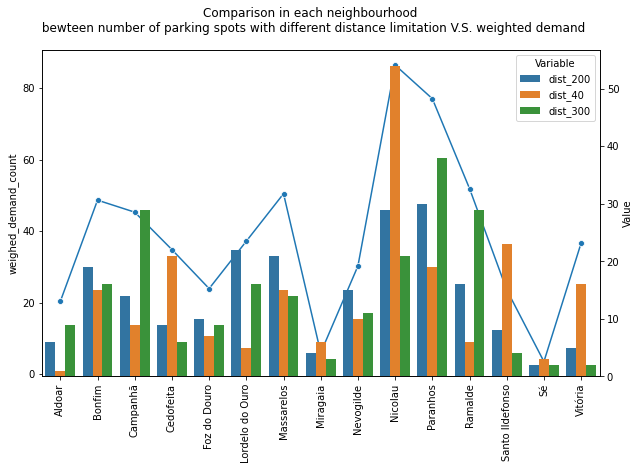

In [ ]:
# summarize the results in previous three cases
tidy = demand_neighborhood_stat[['wof_name','dist_200','dist_40', 'dist_300']]\
  .melt(id_vars='wof_name')\
  .rename(columns=str.title)

ax1 = sns.set_style(style=None, rc=None)
fig, ax1 = plt.subplots(figsize=(10,6))

sns.lineplot(data = demand_neighborhood_stat['weighed_demand_count']
             , marker='o', sort = False, ax=ax1);
ax2 = ax1.twinx()

sns.barplot(x='Wof_Name', y='Value', hue='Variable', data=tidy, ax = ax2);
ax1.set_xticklabels(demand_neighborhood_stat['wof_name'].values, rotation = 90);

plt.suptitle('Comparison in each neighbourhood \n bewteen number of parking spots with different distance limitation V.S. weighted demand');

- Although a radius of 40m gives a result that can best employ our restraints, we would also wish to adhere to reality. Looking at the orange bars in this plot, radius of 40m gives much more concentrated dropoff points around city center: Nicolau, Santo Ildefonso, Cedofeita and Vitoria neighborhoods than the rest as they absorbs much higher weight in the optimization process. In terms of city planning, while we consider what neighborhood can best benefit from this project, we ought not to forget the rest since the reason why these "ignored" neighborhoods are in such a peripheral positions in the planning process might be subjective. The pattern that these orange bars demonstrate, however, is worth to be referenced. 

- We therefore chose a radius of 300m according to research on shared mobility and proceed again. This time, as the green bars show, the distribution is more even across neighborhoods. Yet if we compare 40m and 300m between Nicolau and Paranhos neighborhoods, for 40m Nicolau obtained as much as twice more weight than Parahos, while for 300m the other way around. The map also suggests a distribution that is "too" even, indicating that the constraints are not effectively implemented. 

- To propose a compromized plan, a radius of 200m is then deployed in the model. We can see that the distribution is not as extreme as 40m, but still maintains the pattern bettern than 300m does. 
 - Also, since 300m is a reference distance obtained from bike-share, and scooters are more flexible and phisically accessible, a smaller cover area can further ensure that the demand is met. 

In [ ]:
demand_neighborhood_stat.to_csv('demand_neighborhood_stat_with_result.csv', index  =False)

# 5. Map and Comparsion

Once we decide our final optimzations, we would like to plot the locations along with the demand weight on the map. Let's compare the current old parking locations and our proposed parking locations.

## 5.1 Heatmap with Demand Weight Before

In [ ]:
demand_url = 'https://raw.githubusercontent.com/rainieluo2016/WDL_AKITA/main/Stage_02_2022/demand_stops.geojson'
demand_stops =  gpd.read_file(demand_url)
geometry = [g for g in demand_stops['geometry']]
demand = [d for d in demand_stops['W_Demand']]
lat = []
lng = []

for loc in geometry:
    lat.append(loc.x)
    lng.append(loc.y)

demand_table = pd.DataFrame({'Lat':lat, 'Lng':lng, 'Demand': demand})

latitude = scooter_park_features['y'].mean()
longitude = scooter_park_features['x'].mean()

In [ ]:
# Instantiate a feature group for the incidents in the dataframe
latitude = scooter_park_features['y'].mean()
longitude = scooter_park_features['x'].mean()
park = folium.Map(location=[latitude, longitude], zoom_start=13.5)

# create cluster
marker_cluster = MarkerCluster().add_to(park)

# Loop through the prediction and add each to the incidents feature group
for lat, long, n_spot, name in zip(scooter_park_features.y, scooter_park_features.x
                             , scooter_park_features.n_lugares
                             , scooter_park_features.toponimo):
    name = name + ' parking unit:' + str(n_spot)
    marker_cluster.add_child(
        folium.Marker(
            [lat, long],
            icon = Icon(color = 'blue'),
            popup = Popup(name, max_width = '100%')
        )
    )



park.add_child(marker_cluster)
park.add_child(hm)

As for the current locations, we can see that although the high capacity areas have more parking stations but this way of deployment  does not fully aligned with the current demands. For example, the demand on the Av. do Brasil (the highway near Picamlhos) is at the moderate level but only 6 parking stations were assigned. Similar situations happen at moderate level demand areas.

## 5.2 Heatmap with Demand Weight After

In [ ]:
# Instantiate a feature group for the incidents in the dataframe
latitude_new = new_parking_location_200.geometry.y.mean()
longitude_new = new_parking_location_200.geometry.x.mean()
park_new = folium.Map(location=[latitude_new, longitude_new], zoom_start=13.5)
# create cluster
marker_cluster_new = MarkerCluster().add_to(park_new)

# Loop through the prediction and add each to the incidents feature group
for lat, long, name in zip(new_parking_location_200.geometry.y
                          , new_parking_location_200.geometry.x
                          , new_parking_location_200.name):
    name = name
    marker_cluster_new.add_child(
        folium.Marker(
            [lat, long],
            icon = Icon(color = 'blue'),
            popup = Popup(name, max_width = '100%')
        )
    )



park_new.add_child(marker_cluster_new)
park_new.add_child(hm)

From our optimization result, we can see that we still place many parking stations at the city centers. At the same time, those moderate needed areas have now more stations. 

For example, Av. do Brasil has 6 parking stations which is two more stations compared with the current design.

Also, most of those parking stations are also close to the metro and bus station which could provide more convenience and encourage more usage.

In [ ]:
# finally run this to make sure all the java based image could be knitted 
%%HTML
<script src="require.js"></script>

In [ ]:
# test if html knit works
!jupyter nbconvert --to html /content/wdl_2022_stage2.ipynb

[NbConvertApp] Converting notebook /content/wdl_2022_stage2.ipynb to html
[NbConvertApp] Writing 5544676 bytes to /content/wdl_2022_stage2.html


__Citation__
+ OpenStreet Map
  + https://download.bbbike.org/osm/bbbike/Porto/
  + https://github.com/njanakiev/worlddataleague-workshop/blob/master/01-openstreetmap-amenities.ipynb
  + https://peteris.rocks/blog/openstreetmap-administrative-boundaries-in-geojson/
  + http://overpass-turbo.eu/
  + https://www.youtube.com/watch?v=ksczOcmyEvo
+ Geopandas
  + https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.distance.html
+ Optimization Package
  + PULP - https://coin-or.github.io/pulp/
+ https://www.porto.pt/en/news/electric-scooters-are-set-to-go-and-ride-through-porto-starting-1st-june